# Get and calculate the data
Read the file ["Readme.ipynb"](Readme.ipynb) for more information.

## Modules
Needed to use non-Python functionalities already programmed by someone else.

In [1]:
# Used to convert the API data from json-format into a Python list
from json2xml.utils import readfromurl
import json    # to save the data in "json"-format in a file
import datetime    # to convert Unix time to UTC
# Used to navigate the directories and check for files
import os
# backup directory of this file, because the working directory is changed to save files
get_data_directory = os.getcwd()
import matplotlib.pyplot as plt    # to plot the counties

## Control
Set variables to "True" to trigger the action described by the comment and the variable's name.<br/><br/>
If multiple of the three variables "covid19_use_api", "covid19_use_api_backup" and "covid19_use_polished_data" are set to "True", the last one overwrites all data collected by the others. It is best practice to only set one variable to "True".<br/><br/>
If one data source seems to provide faulty data or the necessary files do not exist, try out the other options.

In [2]:
# The program uses polished geographical data about the counties (True)
# or calls get_geographical_data_of_german_counties.ipynb to produce that data (False)
counties_geography_use_polished_data = True

covid19_use_api = True    # pulls current COVID-19 case numbers from the API
covid19_use_api_backup = False    # polishes backup of old API pull
covid19_use_polished_data = False    # takes old, already polished data

### Check the Controls
Check if the necessary files to run the choices made by the controls above exist. Otherwise the data must be taken from somewhere else.<br/>
Pulling from the API takes a lot of time and ressources. If the user therefore chooses in the controls above not to pull from the API, this choice should only be changed if it is unavoidable.
<br/><br/>
There are three ways how data could be missing:
- Neither polished nor unpolished data about the German COVID-19 cases are saved on the machine. In this case a new pull from the API is inevitable.
- No polished version of the data exists on the machine, but a backup of an old API pull does. Therefore the program initiates a pull from the API or a "pull" from the backup file with the unpolished data.
- No backup of an old API pull exists, but a polished version of the data does. If not, the program initiates a pull from the API or uses the polished data. The file with the polished data exists due to the first condition.

In each respective case the global control variables are changed accordingly.

In [3]:
# move to data directory and create it if neccesary
os.chdir(".."), os.chdir("..")
if not(os.path.isdir("data")):
    os.makedirs("data")
os.chdir("data")
if (not(os.path.isfile("polished_data/german_covid19.txt")) and 
    not(os.path.isfile("unpolished_data/covid19/dates.txt"))):    # no files
    covid19_use_polished_data = False
    covid19_use_api_backup = False
    covid19_use_api = True
elif not(os.path.isfile("polished_data/german_covid19.txt")):    # no polished version
    # and os.path.isfile("unpolished_data/covid19/dates.txt") due to first condition
    covid19_use_polished_data = False
    # ensuring that one of the other two data sources is used
    covid19_use_api_backup = not(covid19_use_api)
elif not(os.path.isfile("unpolished_data/covid19/dates.txt")):    # no backup
    # and os.path.isfile("polished_data/german_covid19.txt") due to first condition
    covid19_use_api_backup = False
    # ensuring that one of the others is used
    covid19_use_polished_data = not(covid19_use_api)
os.chdir(get_data_directory)    # return to original directory

The "number_of_counties" is also set here: It determines how many counties must be present in the data. If there are fewer or more, the current data source is declared a fail and (if possible) another one is used.

In [4]:
number_of_counties = 412

## Get the Geographical Data of Every German County
If "counties_geography_use_polished_data" is set to "True" and the required file exists, the polished data from that file is used. <br/>
If "counties_geography_use_polished_data" is set to "False" by the user or if the required file does not exist, the file "get_geographical_data_of_german_counties.ipynb" is called to provide new polished data.<br/>
For more information on where the data comes from and how it is polished check out the file "get_geographical_data_of_german_counties.ipynb". 

In [5]:
os.chdir(".."), os.chdir(".."), os.chdir("data")   # move to data directory
if not(os.path.isfile("polished_data/german_counties_geography.txt")):
    counties_geography_use_polished_data = False
os.chdir(get_data_directory)    # return to original directory

In [6]:
if counties_geography_use_polished_data:
    os.chdir(".."), os.chdir(".."), os.chdir("data")   # move to data directory
    with open("polished_data/german_counties_geography.txt", "r") as file:
        counties_geography = json.loads(file.read())
    print("Polished county data from file is ready to go!")
    os.chdir(get_data_directory)    # return to original directory
else:
    no_outputs_from_file_get_shapes_of_german_counties = True
    %run get_geographical_data_of_german_counties.ipynb

Polished county data from file is ready to go!


## Get the COVID-19 Cases of Every German County
Saves the COVID-19 cases of every German county since the start of the pandemic in the dictionary "covid19" (reachable by the countys AdmUnitID) and the corresponding dates in the dictionary "non_county_specific_data".

### Helper Functions
**url_county(AdmUnitID, True_for_dates_False_for_covid19_cases = False)**: returns url<br/>
Used to get the url for the COVID-19 cases of the German county determined by the AdmUnitID.<br/>
*AdmUnitId*<br/>
-> identifier of the county whichs covid19 cases should be requested<br/>
*True_for_dates_False_for_covid19_cases* (default: False)<br/>
-> Determines whether the dates in Unix time format or the actual COVID-19 cases should be requested

In [7]:
def url_county(AdmUnitID, True_for_dates_False_for_covid19_cases = False):
    url = ("https://services7.arcgis.com/mOBPykOjAyBO2ZKk/arcgis/rest/services/" +
           "rki_history_hubv/FeatureServer/0/query?where=AdmUnitId%3D" +
           str(AdmUnitID) + "&outFields=")
    if True_for_dates_False_for_covid19_cases:
        return url + "Datum&orderByFields=Datum&f=pjson"
    return url + "KumFall&orderByFields=Datum&f=pjson"

**find_alternative_source_of_data_and_activate_it()**: returns void (modifys multiple global variables)<br/>
Gets called when the data from a data source is faulty. Deletes faulty data to prevent use of faulty data. Checks which other data source could be used and modifies the global variables accordingly.

In [8]:
def find_alternative_source_of_data_and_activate_it():
    global covid19_use_api
    global covid19_use_api_backup
    global covid19_use_polished_data
    global copy_of_covid19_for_debugging_purposes
    global covid19
    global non_county_specific_data
    copy_of_non_county_specific_data_for_debugging_purposes = non_county_specific_data.copy()
    copy_of_covid19_for_debugging_purposes = covid19.copy()
    del non_county_specific_data    # to prevent accidental use of faulty data
    del covid19    # to prevent accidental use of faulty data
    # check if a local pull of the API exists otherwise use the polished data
    os.chdir(".."), os.chdir(".."), os.chdir("data")   # move to data directory
    if os.path.isfile("unpolished_data/covid19/dates.txt"):
        covid19_use_api_backup = True
    elif os.path.isfile("polished_data/german_covid19.txt"):
        covid19_use_polished_data = True
    os.chdir(get_data_directory)    # return to original directory
    # neither local backup nor polished data found
    if not(covid19_use_api_backup) and not(covid19_use_polished_data):
        raise Exception("No usable data found!")

### Pull from API
If "covid19_use_api" is set to "True", the program pulls from the ["COVID-19 Datenhub"](https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/6d78eb3b86ad4466a8e264aa2e32a2e4_0). The data of each county must be pulled separatedly because the API only allows for 1,000 datapoints at a time and all counties times the number of days is well over 100,000. The identifiers of the counties originate from the keys of the dictionary "counties_geography".<br/><br/>
First, the received data is checked: If any county has fewer timestamps than the dates stored in "non_county_specific_data['unixtime']", all data gets deleted to prevent the use of faulty data and an alternative data source is chosen.<br/><br/>
If the unpolished data passes this rudimentary test, it is stored as it is in a ".txt-file" with its AdmUnitID as its name in the folder "covid19" inside the folder "unpolished_data". If any of the folders or any of the files do not yet exist, they are created.<br/>
This file can be used in further executions as local backup of the API-pull.
<br/><br/>
At the end of this chapter the polished version of the data is stored in the dictionary "covid19".

In [9]:
if covid19_use_api:
    print("Pulling from API...")
    covid19 = dict()
    non_county_specific_data = dict()
    # check if the needed directory is available - otherwise create it
    os.chdir(".."), os.chdir(".."), os.chdir("data")   # move to data directory
    if not(os.path.isdir("unpolished_data/covid19")): os.makedirs("unpolished_data/covid19")
    number_of_timestamps = -1
    
    for AdmUnitID in list(counties_geography.keys()):
        # get dates of first county
        if number_of_timestamps == -1:
            raw_dates = readfromurl(url_county(AdmUnitID, True))
            if len(raw_dates['features']) < 200:
                print("The dates of {} sends to little timestamps ({}) - check the url"
                      .format(AdmUnitID, len(raw_dates['features'])))
                find_alternative_source_of_data_and_activate_it()
                covid19_use_api = False
                break
            number_of_timestamps = len(raw_dates['features'])
            non_county_specific_data['unixtime'] = [e['attributes']['Datum'] for e in raw_dates['features']]
            # save raw data
            with open("unpolished_data/covid19/dates.txt", "w") as file:
                file.write(json.dumps(raw_dates))

        # get countys covid19 data
        raw_covid19_data = readfromurl(url_county(AdmUnitID))
        if number_of_timestamps != len(raw_covid19_data['features']):
            print("The provided data from the API does not have the same number of timestamps of " +
                  "{}, it has {}.".format(number_of_timestamps, len(raw_covid19_data['features'])))
            find_alternative_source_of_data_and_activate_it()
            covid19_use_api = False
            break
        with open("unpolished_data/covid19/" + AdmUnitID + ".txt", "w") as file:
            file.write(json.dumps(raw_covid19_data))
        covid19[AdmUnitID] = dict()
        covid19[AdmUnitID]['cases'] = [e['attributes']['KumFall'] for e in raw_covid19_data['features']]

    os.chdir(get_data_directory)    # return to original directory
    if covid19_use_api:
        covid19_use_polished_data = False
        covid19_use_api_backup = False
        print("Covid19 Data directly from API is ready to go!")

Pulling from API...
Covid19 Data directly from API is ready to go!


### "Pull" from Local API Backup
If the use of the data from a local backup of the API-pull is requested and possible, the data is read from the files in the folder "covid19" inside the folder "unpolished_data". The name of the files should represent the "AdmUnitID" of the county.<br/>
The data is polished and stored in the dictionary "covid19" during the reading progress.
<br/><br/>
The received data is checked: If any county has fewer timestamps than the dates stored in "non_county_specific_data['unixtime']", all data gets deleted to prevent the use of faulty data and an alternative data source is chosen.

In [10]:
if not(covid19_use_api) and covid19_use_api_backup:
    print("Reading backup of old API pull...")
    covid19 = dict()
    non_county_specific_data = dict()
    list_of_countys = list(counties_geography.keys())
    # get the dates
    os.chdir(".."), os.chdir(".."), os.chdir("data")   # move to data directory
    with open("unpolished_data/covid19/dates.txt", "r") as file:
        raw_dates = json.loads(file.read())
    non_county_specific_data['unixtime'] = [e['attributes']['Datum'] for e in raw_dates['features']]
    number_of_timestamps = len(non_county_specific_data['unixtime'])

    for root, dirs, files in os.walk('unpolished_data/covid19'):
        # to little dates - something is wrong. Checking here to skip for-loop
        if len(raw_dates['features']) < 200:
            print("There are only {} dates - check your backup or make a new pull from the api."
                  .format(len(raw_dates['features'])))
            find_alternative_source_of_data_and_activate_it()
            covid19_use_api = False
            break
        for filename in files:
            AdmUnitID = filename[:-4]
            if AdmUnitID == 'dates':    # already done
                continue

            list_of_countys.remove(AdmUnitID)
            covid19[AdmUnitID] = dict()
            with open(os.path.join(root, filename), "r") as file:
                covid19[AdmUnitID]['cases'] = [e['attributes']['KumFall'] for e in
                                               json.loads(file.read())['features']]

            if number_of_timestamps != len(covid19[AdmUnitID]['cases']):
                print("The data from file {} does not have {} timestamps, it has {}."
                      .format(filename, number_of_timestamps, len(covid19[AdmUnitID])))
                find_alternative_source_of_data_and_activate_it()
                covid19_use_api_backup = False
                break
    os.chdir(get_data_directory)    # return to original directory

    if len(list_of_countys) > 0 and covid19_use_api_backup:
        print("No backup found for {}".format(list_of_countys))
        find_alternative_source_of_data_and_activate_it()
        covid19_use_api_backup = False

    if covid19_use_api_backup:
        covid19_use_polished_data = False
        covid19_use_api = False
        print("Covid19 Data from (maybe old) API-pull-backup is ready to go!")

## Get the Names of the German Federal States
This data is hardcoded because it is unlikely to change. Even if the names of the federal states become outdated and do not fit the current official name, the functionality of this project will not be affected.
The names are taken from the ["COVID-19 Datenhub"](https://services7.arcgis.com/mOBPykOjAyBO2ZKk/arcgis/rest/services/rki_admunit_hubv/FeatureServer/0/query?where=AdmUnitId%3C20&resultType=none&outFields=*&f=pjson).

In [11]:
if not(covid19_use_polished_data):
    non_county_specific_data['states'] = {
        "1" : "Schleswig-Holstein",
        "2" : "Hamburg",
        "3" : "Niedersachsen",
        "4" : "Bremen",
        "5" : "Nordrhein-Westfalen",
        "6" : "Hessen",
        "7" : "Rheinland-Pfalz",
        "8" : "Baden-Württemberg",
        "9" : "Bayern",
        "10" : "Saarland",
        "11" : "Berlin",
        "12" : "Brandenburg",
        "13" : "Mecklenburg-Vorpommern",
        "14" : "Sachsen",
        "15" : "Sachsen-Anhalt",
        "16" : "Thüringen"}

### Calculate the Seven Days Incidence of the counties
The calculation of the incidence needs the number of cases seven days prior (set to zero if not defined), the cases of the current day (both from "covid19[AdmUnitID]['cases']") and the number of inhabitants of the county ("counties_geography[AdmUnitID]['population']").
<br/><br/>
To get all new cases in that county within the last seven days the program subtracts the accumulated cases seven days earlier from the accumulated cases of the current day. Afterwards this number of cases is divided by the county's population. In order to scale it to 100,000 inhabitants, the result is multiplied by 100,000.<br/>
This is done for every case number of every county.
<br/><br/>
The highest and lowest seven days incidence and the highest and lowest case number are stored in the dictionary "non_county_specific_data" as a reference.
<br/><br/>
At the end the scaled version of the incidences for the correlation analyses is generated: 
 - subtract the lowest value from every value
 - divide every value by the biggest value
 - multiply every value with two
 - subtract one from every value

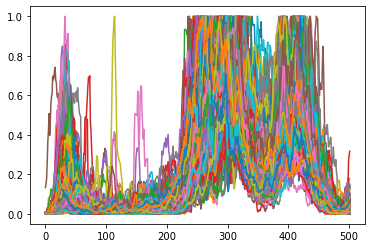

In [12]:
if not(covid19_use_polished_data):
    non_county_specific_data['highest_case_number'] = 0
    non_county_specific_data['lowest_case_number'] = 100000000000000
    non_county_specific_data['highest_incidence'] = 0
    non_county_specific_data['lowest_incidence'] = 100000000000000
    for AdmUnitID in covid19.keys():
        covid19[AdmUnitID]['incidences'] = list()
        for timestamp in range(len(covid19[AdmUnitID]['cases'])):
            cases_7_days_prior = 0
            cases_on_day = covid19[AdmUnitID]['cases'][timestamp]
            if timestamp >= 7:
                cases_7_days_prior = covid19[AdmUnitID]['cases'][timestamp - 7]
            incidence = (((cases_on_day - cases_7_days_prior) * 100000) /
                         counties_geography[AdmUnitID]['population'])
            covid19[AdmUnitID]['incidences'].append(incidence)
            if non_county_specific_data['highest_case_number'] < cases_on_day:
                non_county_specific_data['highest_case_number'] = cases_on_day
            if non_county_specific_data['lowest_case_number'] > cases_on_day:
                non_county_specific_data['lowest_case_number'] = cases_on_day
            if non_county_specific_data['highest_incidence'] < incidence:
                non_county_specific_data['highest_incidence'] = incidence
            if non_county_specific_data['lowest_incidence'] > incidence:
                non_county_specific_data['lowest_incidence'] = incidence
    for county in covid19.values():
        county['scaled_incidences'] = list()
        for incidence in county['incidences']:
            county['scaled_incidences'].append((incidence - min(county['incidences']))
                /(max(county['incidences']) - min(county['incidences'])))
        plt.plot(county['scaled_incidences'])
    plt.show()

### Get the Cases, Incidences and Inhabitants of Germany
The number of inhabitants of Germany is calculated by adding the number of inhabitants of the counties. The same applies to accumulated number of COVID-19 cases for every day. The seven days incidence is calculated as described above.

In [13]:
if not(covid19_use_polished_data):
    non_county_specific_data['population_germany'] = 0
    for county in counties_geography.values():
        non_county_specific_data['population_germany'] += county['population']

    non_county_specific_data['cases_germany'] = (
        len(non_county_specific_data['unixtime'])*[0])

    for AdmUnitID in covid19.keys():
        for timestamp in range(len(covid19[AdmUnitID]['cases'])):
            cases_on_day = covid19[AdmUnitID]['cases'][timestamp]
            non_county_specific_data['cases_germany'][timestamp] = (cases_on_day +
            non_county_specific_data['cases_germany'][timestamp])

    non_county_specific_data['incidences_germany'] = list()
    for timestamp in range(len(non_county_specific_data['cases_germany'])):
        cases_7_days_prior = 0
        cases_on_day = non_county_specific_data['cases_germany'][timestamp]
        if timestamp >= 7:
            cases_7_days_prior = non_county_specific_data['cases_germany'][timestamp - 7]
        incidence = (((cases_on_day - cases_7_days_prior) * 100000) /
                     non_county_specific_data['population_germany'])
        non_county_specific_data['incidences_germany'].append(incidence)

## Get the Districts and their Counties
The first two or three digits of the AdmUnitID determine the district.

In [14]:
if not(covid19_use_polished_data):
    districts = dict()
    for AdmUnitId, county in counties_geography.items():
        district_id = AdmUnitId[:-2]
        # adding Berlin to the district of Potsdam
        #if district_id == "110": district_id = "120"
        # adding Bremen and Bremerhaven to the district of Lüneburg
        #if district_id == "40": district_id = "33"
        # adding Hamburg to the district of Lüneburg
        #if district_id == "20": district_id = "33"

        if district_id not in districts.keys():
            days_num = len(non_county_specific_data["unixtime"])
            districts[district_id] = dict(counties = list(),
                                         population = 0,
                                         area_in_m2 = 0,
                                         population_density = 0,
                                         cases = days_num*[0],
                                         incidences = list(),
                                         incidences_scaled = list())
        districts[district_id]["counties"].append(AdmUnitId)

## Calculate the Population Density of the Districts and the Seven Days Incidence
The population density is calculated by dividing the population number by the area in square meters. In order to scale it to kilometers, the result is multiplied by 1,000,000. The population number and the area in square meters of a district equal the sum of the counties with the same first two/three digits in the AdmUnitID.<br/>
The final result is stored in the dictionary "non_county_specific_data".
<br/><br/>
The population of the counties is calculated in the file get_geographical_data, because it is saved with the geographical data.
The population density of the german districts is calculated here because it is saved in the non_county_specific variable, which is created and saved here.
<br/><br/>
Add up the cases of the counties and calculate the seven days incidence and scale it as described above.

In [15]:
if not(covid19_use_polished_data):
    for district in districts.values():
        for AdmUnitId in district["counties"]:
            district["population"] += counties_geography[AdmUnitId]["population"]
            district["area_in_m2"] += counties_geography[AdmUnitId]["area_in_m2"]
            for case_index in range(len(covid19[AdmUnitId]["cases"])):
                district["cases"][case_index] += covid19[AdmUnitId]["cases"][case_index]
        district["population_density"] = ((district["population"] * 1000000)/
                                          district["area_in_m2"])

In [16]:
if not(covid19_use_polished_data):
    for district in districts.values():
        for timestamp in range(len(district['cases'])):
            cases_7_days_prior = 0
            cases_on_day = district['cases'][timestamp]
            if timestamp >= 7:
                cases_7_days_prior = district['cases'][timestamp - 7]
            incidence = (((cases_on_day - cases_7_days_prior) * 100000) /
                         district['population'])
            district['incidences'].append(incidence)
    
    for district in districts.values():
        for incidence in district['incidences']:
            district['incidences_scaled'].append((incidence - min(district['incidences']))
                /(max(district['incidences']) - min(district['incidences'])))

## Calculate the Correlation

In [ ]:
%run get_s

## Check and Save the Polished Covid19 Data
Before the COVID-19 cases are saved in the file "german_covid19.txt" inside the folder "polished_data", they are checked once again to ensure that during the polishing nothing gets lost or is changed.
<br/>
It is checked if there are fewer or more counties than defined in the variable number_of_counties and if every list of cases is as long as the dedicated dates.

In [17]:
if not(covid19_use_polished_data):
    covid19_data_seems_to_be_flawless = True    # Assume everything is correct
    if len(covid19) != number_of_counties:
        print("covid19 has not the right amount of counties: {} instead of {}."
                .format(len(covid19), number_of_counties))
        covid19_data_seems_to_be_flawless = False
    for AdmUnitID in covid19.keys():
        if len(covid19[AdmUnitID]['cases']) != len(non_county_specific_data['unixtime']):
            print("The county {} has not the right amount of dates: {} instead of {}."
                    .format(county, len(covid19[AdmUnitID]['cases']),
                            len(non_county_specific_data['unixtime'])))
            covid19_data_seems_to_be_flawless = False

In [18]:
if not(covid19_use_polished_data) and covid19_data_seems_to_be_flawless:
    os.chdir(".."), os.chdir(".."), os.chdir("data")   # move to data directory
    # check if the needed directory is availlable - otherwise create it
    if not(os.path.isdir("polished_data")): os.makedirs("polished_data")
    with open("polished_data/german_covid19.txt", "w") as file:
        file.write(json.dumps((covid19, non_county_specific_data, districts)))
    os.chdir(get_data_directory)    # return to original directory
    print("Saved seemingly flawless covid19 data.")

Saved seemingly flawless covid19 data.


## Get the Polished Data
If the pull from the API and/or the "pull" from the local backup failed or the user chose to use the polished data, the file "german_covid19.txt" inside the folder "polished_data" is opened and the data is stored in the variables "covid19" and "non_county_specific_data".

In [19]:
if covid19_use_polished_data:
    covid19_use_api_backup = False
    covid19_use_api = False
    os.chdir(".."), os.chdir(".."), os.chdir("data")   # move to data directory
    with open("polished_data/german_covid19.txt", "r") as file:
        covid19, non_county_specific_data, districts = json.loads(file.read())
    os.chdir(get_data_directory)    # return to original directory
    print("Polished covid19 data from file is ready to go!")

##  Add UTC Time and Additional Dates
Humans are generally not used to the Unix time; this is why the more accessible kind of time format UTC is chosen. The exact hour in Germany and the time shift are not taken to account because the data is only compared to other data with the same time shift.
<br/><br/>
The UTC time is added after saving the data because the UTC time format cannot be saved in json format. Therefore it must always be generated anew. Calculating it inside the file "get_data.ipynb" keeps the plotting of the data strictly separated from the pulling and polishing of the data.

In [20]:
non_county_specific_data['UTC'] = [datetime.date.fromtimestamp(date//1000).strftime('%d.%m.%Y')
                           for date in non_county_specific_data['unixtime']]

In [21]:
non_county_specific_data['UTC+7days'] = non_county_specific_data['UTC'].copy()
for e in range(1,8):
    non_county_specific_data['UTC+7days'].insert(0,
    datetime.date.fromtimestamp((non_county_specific_data['unixtime'][0]
                                - (e*86400000))//1000).strftime('%d.%m.%Y'))